In [147]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency, ttest_ind, pearsonr
from sklearn import set_config


set_config(transform_output="pandas")
# link to Kaggle competition
# https://www.kaggle.com/competitions/regression-prediction-prix-immobilier/overview

# Dataset
# OverallQual : Qualité globale des matériaux et de la finition. Souvent très corrélé au prix de vente. (note sur 10, entier)
# GrLivArea : Surface habitable hors sous-sol. Directement liée à la taille de la maison.
# TotalBsmtSF : Superficie totale du sous-sol. Ajoute une grande valeur à la propriété.
# 1stFlrSF : Superficie du rez-de-chaussée. Indique la taille de la maison.
# YearBuilt : Année de construction. Les maisons plus récentes ont tendance à se vendre à un prix plus élevé.
# YearRemodAdd : Année de rénovation. Les rénovations récentes peuvent augmenter le prix.
# GarageCars : Capacité du garage en nombre de voitures. Un élément clé pour de nombreux acheteurs.
# GarageArea : Taille du garage en pieds carrés.
# FullBath : Nombre de salles de bains complètes. Un facteur important pour le confort de la maison.
# TotRmsAbvGrd : Nombre total de pièces au-dessus du sol (hors salles de bains). Plus il y a de pièces, plus le bien est généralement cher.
# KitchenQual : Qualité de la cuisine. Une cuisine de haute qualité ajoute une grande valeur.
# Fireplaces : Nombre de cheminées. Une caractéristique qui peut augmenter l'attrait et la valeur d'une propriété.
# LotArea : Surface totale du terrain. La taille du lot est un facteur important, notamment dans les zones urbaines.
# Neighborhood : Emplacement physique au sein des limites de la ville. L'emplacement a un impact majeur sur les prix de l'immobilier.
# ExterQual : Qualité du matériau extérieur. Un indicateur de la qualité globale de la maison.
# SalePrice : Prix de vente de la maison. C'est la variable cible que nous devons prédire.

df = pd.read_csv('data/train_set.csv')


### Check NaN

In [111]:
df.isna().sum(axis=1)

0       0
1       0
2       0
3       0
4       0
       ..
1175    0
1176    0
1177    0
1178    0
1179    0
Length: 1180, dtype: int64

#### Plot distributions

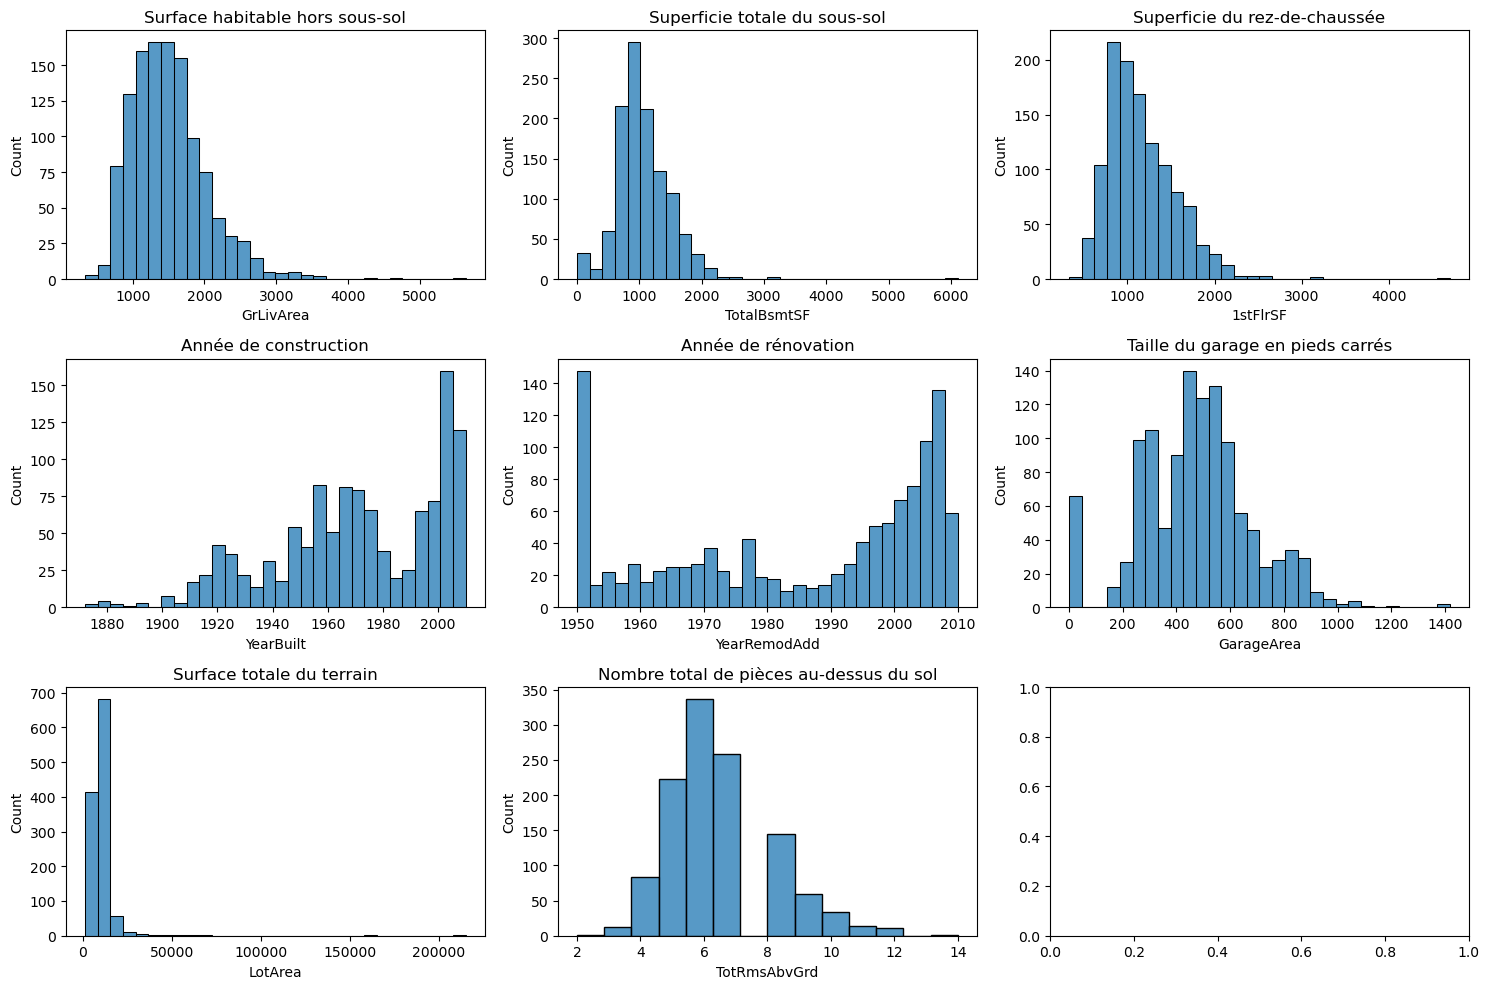

In [112]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
sns.histplot(df, x="GrLivArea", bins=30, ax=axs[0, 0])
axs[0, 0].set_title('Surface habitable hors sous-sol')
sns.histplot(df, x="TotalBsmtSF", bins=30, ax=axs[0, 1])
axs[0, 1].set_title('Superficie totale du sous-sol')
sns.histplot(df, x="1stFlrSF", bins=30, ax=axs[0, 2])
axs[0, 2].set_title('Superficie du rez-de-chaussée')
sns.histplot(df, x="YearBuilt", bins=30, ax=axs[1, 0])
axs[1, 0].set_title('Année de construction')
sns.histplot(df, x="YearRemodAdd", bins=30, ax=axs[1, 1])
axs[1, 1].set_title('Année de rénovation')
sns.histplot(df, x="GarageArea", bins=30, ax=axs[1, 2])
axs[1, 2].set_title('Taille du garage en pieds carrés')
sns.histplot(df, x="LotArea", bins=30, ax=axs[2, 0])
axs[2, 0].set_title('Surface totale du terrain')
sns.histplot(df, x="TotRmsAbvGrd", bins=14, ax=axs[2, 1])
axs[2, 1].set_title('Nombre total de pièces au-dessus du sol')
fig.tight_layout()


### Categorical columns

In [113]:
print(f"OverallQual = {df["OverallQual"].unique()}")
print(f"GarageCars = {df["GarageCars"].unique()}")
print(f"FullBath = {df["FullBath"].unique()}")
print(f"TotRmsAbvGrd = {df["TotRmsAbvGrd"].unique()}")
print(f"Fireplaces = {df["Fireplaces"].unique()}")
print(f"KitchenQual = {df["KitchenQual"].unique()}")
print(f"Neighborhood = {df["Neighborhood"].unique()}")

OverallQual = [ 7  6  8  5  9  4 10  3  1  2]
GarageCars = [2 1 3 0 4]
FullBath = [2 1 3 0]
TotRmsAbvGrd = [ 8  6  7  5 11  4  9 10 12  3  2 14]
Fireplaces = [0 1 2 3]
KitchenQual = ['Gd' 'TA' 'Ex' 'Fa']
Neighborhood = ['CollgCr' 'Veenker' 'Somerst' 'OldTown' 'BrkSide' 'NridgHt' 'Sawyer'
 'NAmes' 'SawyerW' 'IDOTRR' 'Edwards' 'Timber' 'Mitchel' 'Gilbert'
 'StoneBr' 'ClearCr' 'Crawfor' 'NWAmes' 'NPkVill' 'Blmngtn' 'BrDale'
 'NoRidge' 'SWISU' 'MeadowV' 'Blueste']


### Analyse de ExterQual 
Qualité du matériau extérieur. Un indicateur de la qualité globale de la maison.

ExterQual = ['Gd' 'TA' 'Ex' 'Fa']


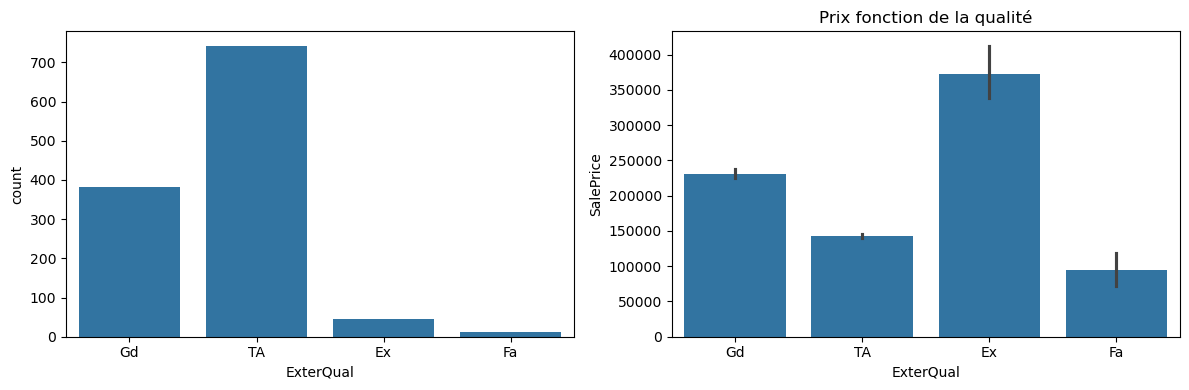

In [114]:
print(f"ExterQual = {df["ExterQual"].unique()}")

# ExterQual
# Ex = Excellent
# Gd = Good
# TA = Typical
# Fa = Fair

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(df, x="ExterQual", ax=axs[0])
sns.barplot(df, x="ExterQual", y="SalePrice", ax=axs[1])
axs[1].set_title("Prix fonction de la qualité")
fig.tight_layout()


### Analyse de GrLivArea

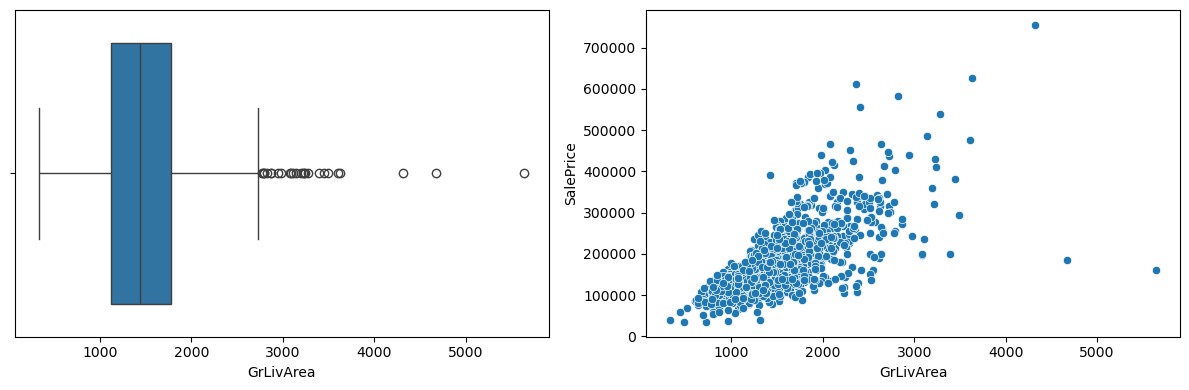

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))                 
sns.boxplot(df, x="GrLivArea", ax=axs[0])
sns.scatterplot(df, x="GrLivArea", y="SalePrice", ax=axs[1])
fig.tight_layout()   

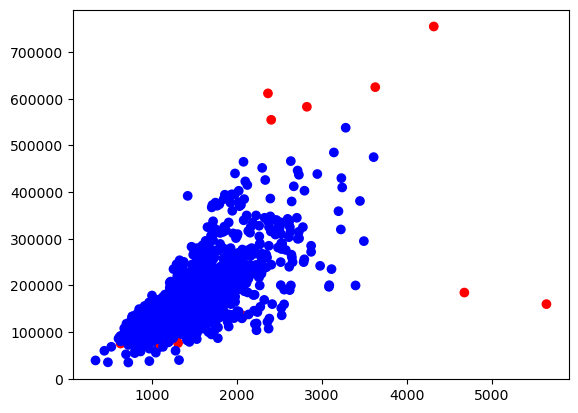

In [130]:
# check outliers
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

detection_model = LocalOutlierFactor(n_neighbors=10, contamination=0.01)
outliers = detection_model.fit_predict(df[["GrLivArea", "SalePrice"]])
plt.scatter(df["GrLivArea"], df["SalePrice"], c=outliers, cmap="bwr_r")
plt.show()

# Filtering rows where series_filter is -1
# df_outliers = df[outliers == -1].sort_values(by=['GrLivArea'])
# df_outliers

### Analyse de LotArea

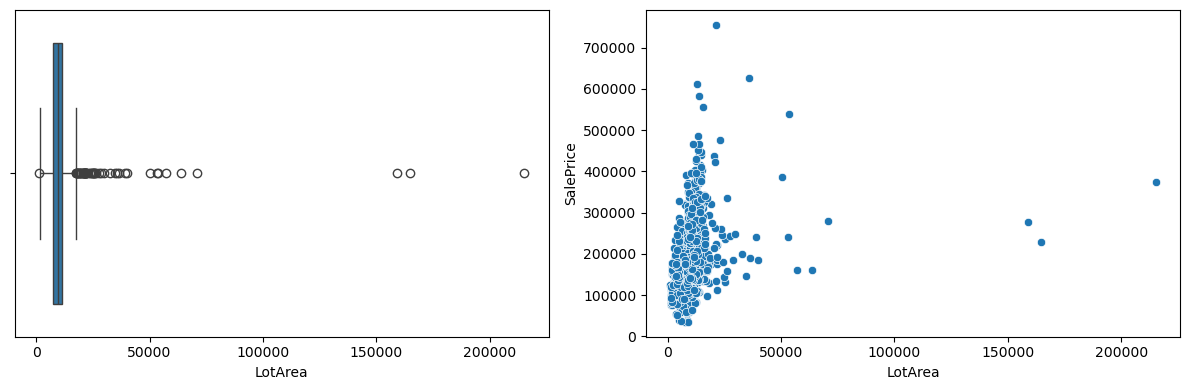

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))                 
sns.boxplot(df, x="LotArea", ax=axs[0])
sns.scatterplot(df, x="LotArea", y="SalePrice", ax=axs[1])
fig.tight_layout()   

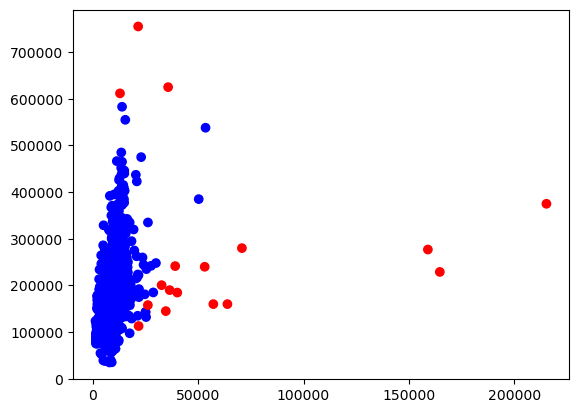

In [ ]:
# check outliers
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

detection_model = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
outliers = detection_model.fit_predict(df[["LotArea", "SalePrice"]])
plt.scatter(df["LotArea"], df["SalePrice"], c=outliers, cmap="bwr_r")
plt.show()

# Filtering rows where series_filter is -1
df_outliers = df[outliers == -1].sort_values(by=['LotArea'])
#df_outliers

### Analyse de Neighboorhood

In [ ]:
#print(df["Neighborhood"].value_counts())
#sns.catplot(df, x="Neighborhood", y="SalePrice", kind="bar", height=4, aspect=3)

results = df.groupby(['Neighborhood']).agg({'SalePrice': ['mean']}).reset_index()
results.columns = ['Neighborhood', 'SalePrice']
results = results.sort_values(by=['SalePrice']).reset_index()
results


### Analyse de TotalBsmtSF
Superficie totale du sous-sol

Text(0.5, 1.0, 'Prix fonction de la superficie du sous-sol')

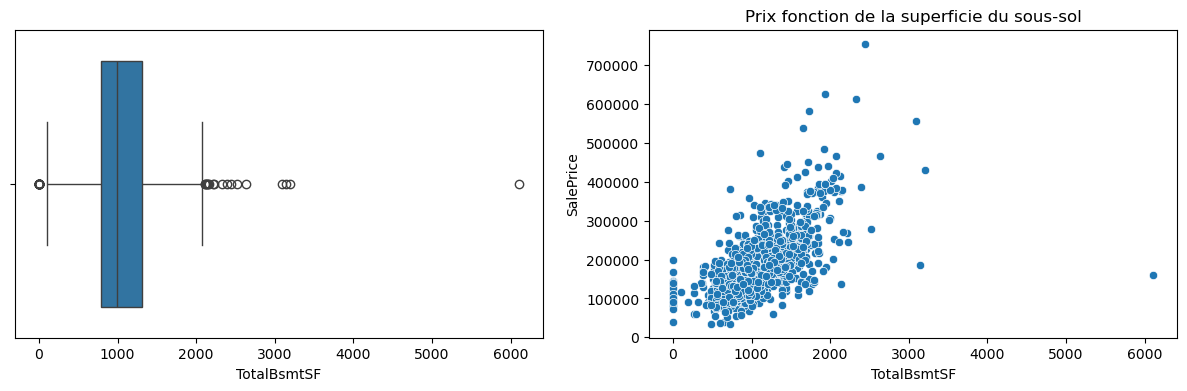

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(df, x="TotalBsmtSF", ax=axs[0])
sns.scatterplot(df, x="TotalBsmtSF", y="SalePrice", ax=axs[1])
axs[1].set_title('Prix fonction de la superficie du sous-sol')

### Analyse GarageArea

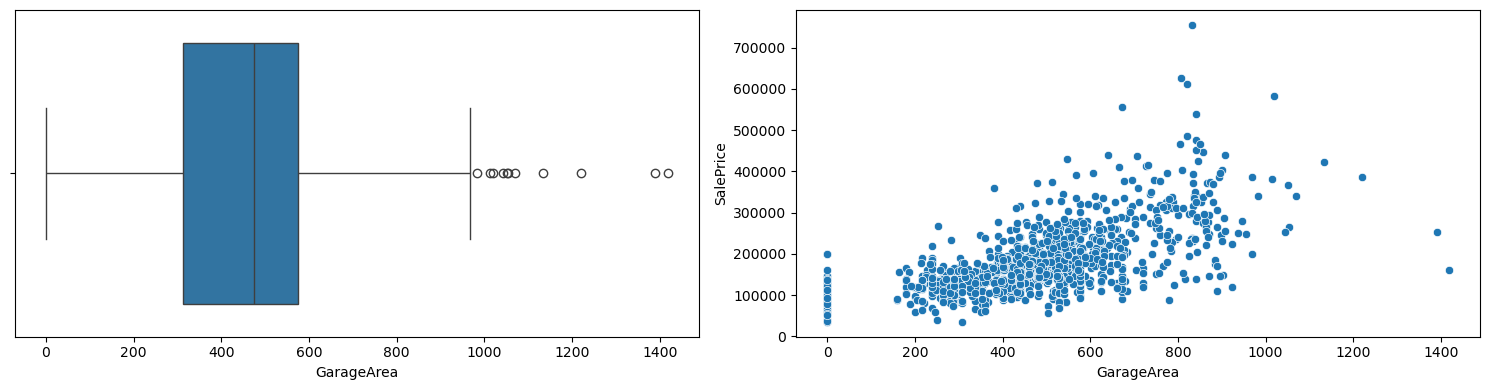

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(df, x="GarageArea", ax=axs[0])
sns.scatterplot(df, x="GarageArea", y="SalePrice", ax=axs[1])
fig.tight_layout()
plt.show()

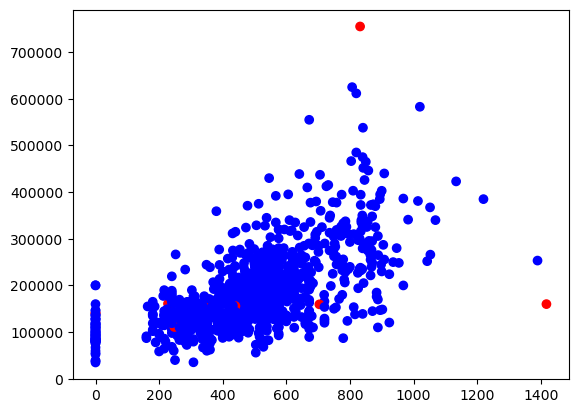

In [145]:
# check outliers
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

detection_model = LocalOutlierFactor(n_neighbors=10, contamination=0.01)
outliers = detection_model.fit_predict(df[["GarageArea", "SalePrice"]])
plt.scatter(df["GarageArea"], df["SalePrice"], c=outliers, cmap="bwr_r")
plt.show()

# Filtering rows where series_filter is -1
df_outliers = df[outliers == -1].sort_values(by=['GarageArea'])
#df_outliers

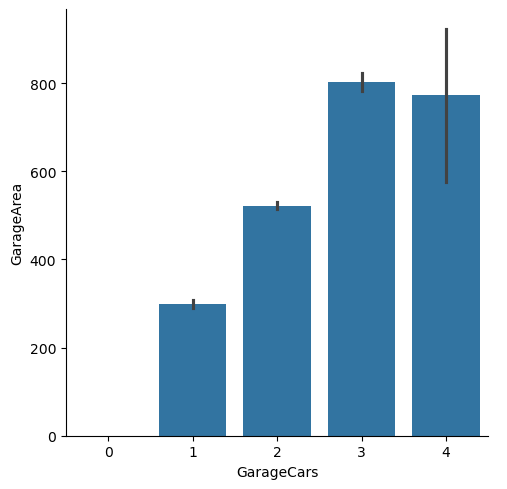

In [148]:
sns.catplot(df, x="GarageCars", y="GarageArea", kind="bar")

### Analyse YearRemodAdd

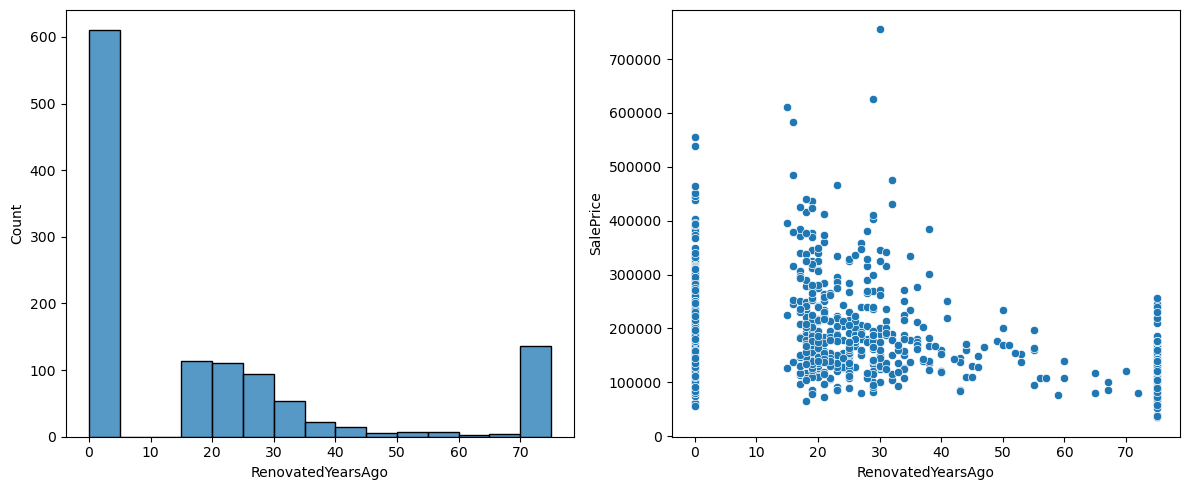

<Axes: xlabel='RenovatedYearsAgo', ylabel='Count'>

In [149]:
# Substract YearRemodAdd to Yearbuilt to check if house has been renovated

def get_renovated_years_ago(x):
   if(x.YearRemodAdd == x.YearBuilt):
      return 0
   else:
      return 2025 - x.YearRemodAdd
   
df_renovated_ago = df.apply(lambda x: get_renovated_years_ago(x), axis=1)
df_renovated_ago.name = "RenovatedYearsAgo"
# df_renovated_ago
temp_df = pd.concat([df_renovated_ago, df["SalePrice"]], axis=1)
#temp_df

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_renovated_ago, ax=axs[0])
sns.scatterplot(temp_df, x="RenovatedYearsAgo", y="SalePrice", ax=axs[1])
fig.tight_layout()
plt.show()

sns.histplot(df, x="YearRemodAdd", ax=axs[0])
